In [27]:
from scipy.io import loadmat
import mne
import pandas as pd
import numpy as np

### Info on the study I am trying to replicate and improve on
1. The full study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4436356/
2. The data description (including data dictionary): https://lampx.tugraz.at/~bci/database/004-2015/description.pdf

### Investigating which Python EEG libraries to use
There are several Python libraries which are designed to help process EEG data. I'll investigate each.

- EEGLib
    - https://www.sciencedirect.com/science/article/pii/S2352711021000753
    - Primarily used for feature extraction after the data has been processed, but it does have some preprocessing capability
    - Appears to be written to allow visual inspection of data and then creation of features based on the selected point - certainly worth investigating
- MNE Python
    - https://mne.tools/dev/auto_tutorials/intro/10_overview.html
    - Appears to be the most popular python extension for EEG work
    - There is a hell of a lot going on here. Lots of transformations, etc. It seems to have very robust documentation, however, and I think it will work on my data
    - Comes with sample jupyter notebooks and a sample dataset to see the tools in action
    - Seems like I should definitely use MNE, and then I could consider doing EEGlib if I want to go above and beyond / see if I can get better features for modeling that way
- EEGLab
    - EEGlab is not a Python library - it is based on Matlab and also uses Octave. It appears to be the most popular tool for EEG analysis - however I assume Python's machine learning tools are much more powerful
    - It is possible to run some EEGlab commands in Python if I absolutely had to: https://eeglab.org/others/EEGLAB_and_python.html
    
I set up an mne environment (which does not currently include sci kit learn) to start to see if I can ingest this data. Would need to then open the converted data in my base environment to model it with sklearn, or alternatively pull sklearn into my mne environment.

**I installed MNE with core functionality only** per the instructions on this page: https://mne.tools/stable/install/manual_install.html

I tried to install the full package with 3D vizualizations as suggested via mamba, but got an error in the install.

### Loading data into MNE

First, we will use scipy to open the .mat file. Then, we need to prepare the data to be loaded into MNE. MNE requires both the array of data (with shape samples x channels) and an info file with the channel names, sample rate, channel types, and channel positions.

In the data documentation they listed the channel positions they used, but I cannot be sure they are listed in the documentation in the same order as the data is stored in the dataset.

For the purposes of building a model I don't need the channel positions. However, when I'm done with the model, it would be useful to be able to say which electrode positions would be necessary for a commercialized product based on these insights. As a result, I will assume that the electrodes are listed in the same order in the data as in the documentation, but I will need to sense-check my insights at the end (e.g., for the tasks focused on imagining motion of the hands and feet, the electrodes near the motor cortex should get the strongest signal. If that is not the case when I examine which electrodes are generating the signal at the end, then it is likely that the electrode data is not stored in the same order as listed in the documentation.

Here is the technique to use to read data into MNE from an array: https://mne.tools/0.16/auto_examples/io/plot_objects_from_arrays.html#sphx-glr-auto-examples-io-plot-objects-from-arrays-py

In [2]:
#use scipy loadmat to load .mat data in
annots = loadmat('data/A.mat')

In [3]:
print(annots)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Apr 20 09:36:19 2015', '__version__': '1.0', '__globals__': [], 'data': array([[array([[(array([[ -4.64026856,  -1.28023194,  -3.15709163, ...,  -3.14488441,
                         -5.09803922,  -2.96177615],
                       [ -4.91493095,  -1.02693217,  -3.50499733, ..., -12.49256123,
                         -6.72465095,  -7.90264744],
                       [ -4.03295949,   0.08697642,  -2.79392691, ..., -18.3947509 ,
                         -6.37369345, -10.58823529],
                       ...,
                       [  3.71252003,   4.13672084,  -7.97894255, ..., -10.55161364,
                          9.25459678,  -8.28107118],
                       [  2.16830701,   3.37071794,  -4.78980697, ...,  -5.08278019,
                          7.49065385,  -3.60570687],
                       [  0.30365454,   1.12764172,   0.09308003, ...,   0.12359808,
                          1.79598688,   0.12054627]

In [4]:
annots.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [5]:
any('AFz' in x for x in annots)

False

In [6]:
len(annots)

4

In [7]:
[data] = annots['data']

In [8]:
len(data)

2

In [9]:
[data_0] = data[0]
[data_1] = data[1]

I hypothesize at this point that data_0 and data_1 are the trial data for subject A on day 1 and day 2 respectively, they appear to be the same shape and have a lot of data in each.

In [10]:
df_0 = pd.DataFrame(data_0)

In [11]:
df_0

,X,y,trial,fs,classes,session
0,"[[-4.640268558785382, -1.28023193713283, -3.15...","[[4], [2], [1], [4], [3], [4], [5], [4], [3], ...","[[5121], [8517], [11911], [15175], [18588], [2...",[[256]],"[[[WORD], [SUB], [NAV], [HAND], [FEET]]]",[[1]]


Confirmed - each of these highest-level arrays captures all the information from each of the two trials on this subject. - so data_1 has all this same information for the second session with this trial participant.

In [12]:
[X] = df_0['X']

In [13]:
X.shape

(714810, 30)

This is great news - the 30 channels for the 30 electrodes I was expecting are here. X is the raw data I'll feed into MNE.

**Now to construct the info file that will accompany the raw data into MNE**

Unfortunately the channel names (locations on the head on which the 30 electrodes were placed) are not recorded in this dataset. Per my comment above, I will assume the data is stored in the same order that the channels are listed in the documentation, and at the end of the project, I can sense check that assumption by looking at which channels recorded the strongest signal for the motor-cortex intensive tasks. In addition, channels AFz and CPz should not appear to activate strongly during any of the trials - those are the reference and ground electrodes placed on the left and right mastoid (behind the ear).

Even if the channels are incorrect, it won't impact my ability to answer the problems statement, because I can still construct a model which predicts yes/no - I just wouldn't be able to recommend where to place electrodes for a commercialized version of this study.

Here is the documenation on an mne info file: https://mne.tools/0.16/generated/mne.create_info.html#mne.create_info

In [14]:
ch_names = ['AFz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T3', 
            'C3', 'Cz', 'C4', 'T4', 'CP3', 'CPz', 'CP4', 'P7', 'P5', 'P3', 
            'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'PO4', 'O1', 'O2']
#per the documentation data was collected at 256 hertz
sfreq = 256
#all channel types are eeg sensors
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

### Loading this data for our first trial with our first participant into MNE

In [53]:
#transpose data to get it in correct shape
#This raw array is the simplest way to organize data in mne
subject_A_session_1_raw = mne.io.RawArray(X.T, info)

Creating RawArray with float64 data, n_channels=30, n_times=714810
    Range : 0 ... 714809 =      0.000 ...  2792.223 secs
Ready.


Next we'll construct the events array as follows:
- 3 columns x number of trials in dataset
- First column is the sample # where the trial occurred - locates event in time in our data array
    - We'll need to transform this in our data. MNE looks for the event as the time at which the stimulus began, whereas in our dataset the timestamp we've been provided is when their trial started. The stimulus occured 3 seconds after the beginning of each trial in all cases.
- 2nd column is a 0 in our case - only used with analog signals
- 3rd column is the event ID, what kind of event this trial was testing

Based on this documentation:
https://mne.tools/0.16/auto_examples/io/plot_objects_from_arrays.html#sphx-glr-auto-examples-io-plot-objects-from-arrays-py
https://mne.tools/0.16/generated/mne.EpochsArray.html#mne.EpochsArray 
https://mne.tools/dev/auto_tutorials/intro/20_events_from_raw.html 
https://mne.tools/stable/glossary.html#term-events

In [47]:
[trials] = df_0['trial']
middle = np.array([[0 for num in range(200)]])
[event_ids] = df_0['y']

In [59]:
#Add 3 seconds (with 256Hz sample rate) to get stimulus times
event_times = np.array([[trial_time + (256 * 3) 
                         for trial_time in trials.flatten()]])

In [62]:
#Construct the events array
events = np.concatenate((event_times.T, middle.T, event_ids), axis=1)

In [52]:
events_dict = {'brainteaser/word': 1, 'brainteaser/subtraction': 2, 
               'brainteaser/navigation': 3, 'motor/hang': 4, 'motor/feet': 5}

In [72]:
#tmin and tmax are -3 and 7 seconds respectively per trial definition 
#in our experiment
subject_A_session_1_epoch = mne.Epochs(subject_A_session_1_raw, 
                                       events=events, 
                                       event_id=events_dict, 
                                       tmin=-3, tmax=7)

Not setting metadata
200 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Note that this defaulted to several settings in processing our epochs that we could customize - full documentation here:
https://mne.tools/stable/generated/mne.Epochs.html

### Let's get some initial visualizations of our data
At first blush it looks like the scale is way off - need to set that (or transform the data) if I want to be able to see these curves

Using data from preloaded Raw for 162 events and 2561 original time points ...
Opening epochs-browser...
Using data from preloaded Raw for 1 events and 2561 original time points ...


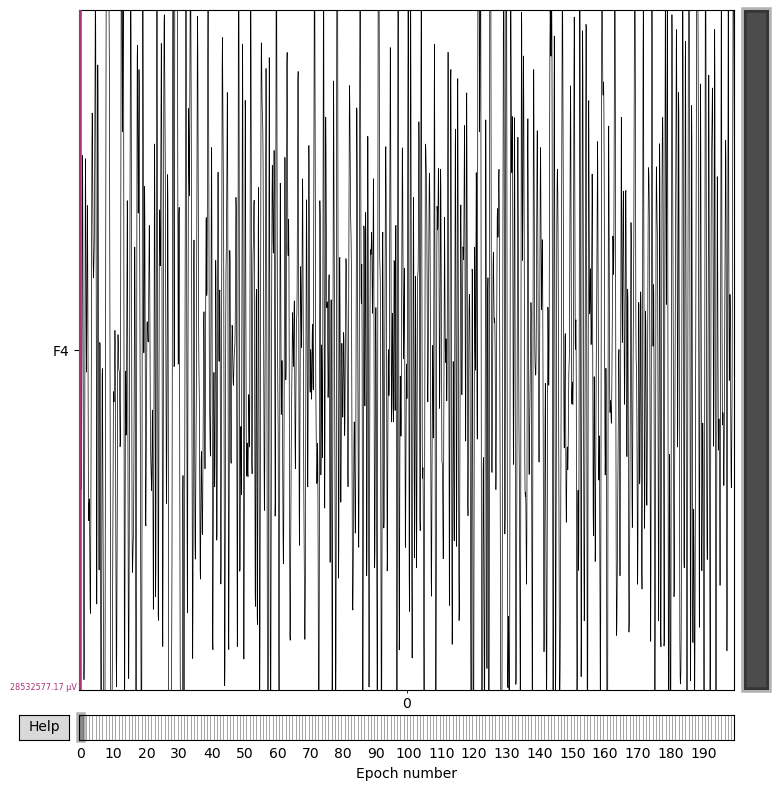

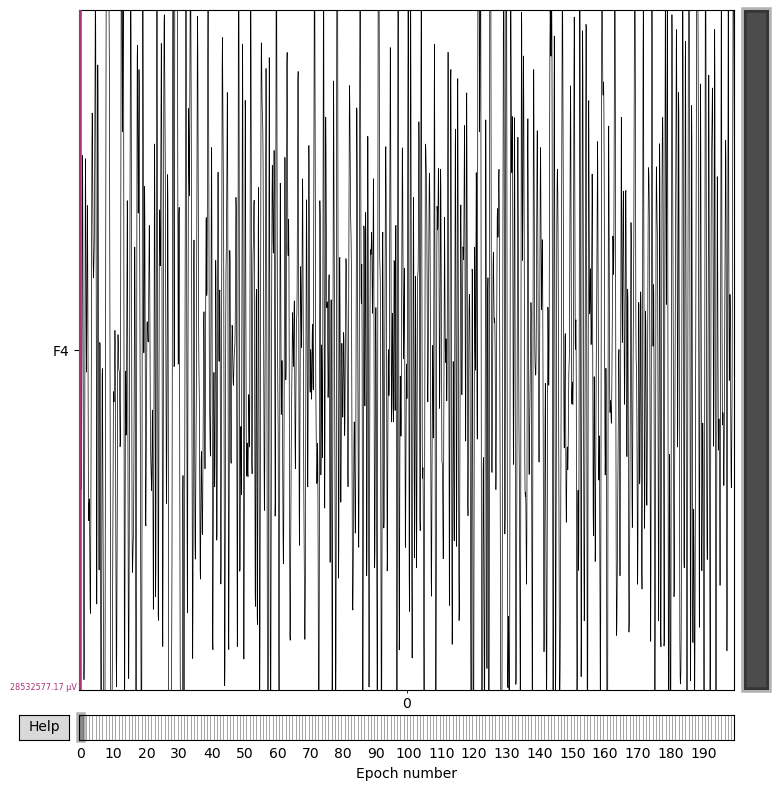

In [87]:
#Looking at 5th channel, 1 epoch at a time
subject_A_session_1_epoch.plot(picks=[4], scalings='auto', n_epochs=1)

Looks like we need to scale this thing if I want to be able to see a clear signal. Some kind of averaging of the data also looks like it would be helpful - but one step at a time. Let's try MNE's built in scalers first.

We'll try it two ways - using MNE's default scaler for EEG data, and then by mean and standard deviation (sklearn standard scaling) within each channel.

In [76]:
mne_default_scaler = mne.decoding.Scaler(info=info)
sklearn_scaler = mne.decoding.Scaler(scalings=='mean')

**First let's see what our data looks like with the mne default scaler**

In [78]:
X = subject_A_session_1_epoch.get_data()
y = subject_A_session_1_epoch.events
subject_A_session_1_mne_scaled = mne_default_scaler.fit_transform(X, y)

Using data from preloaded Raw for 200 events and 2561 original time points ...


In [84]:
subject_A_session_1_mne_scaled

array([[[  9366928.18328447,   4575595.30772179,    904274.63937663,
         ...,    361053.45985424,   1728261.82179824,
           2222654.1312512 ],
        [ 13549229.64262438,  16271439.14899502,  12923609.74485983,
         ...,  40060254.28594474,  20211318.60272204,
          -4224479.06264761],
        [ -6389894.99550712,  -9508839.07119187,  -6734748.89037246,
         ..., -23675315.00008483, -20528904.68498603,
         -13024517.71619072],
        ...,
        [  5668248.42600411,   1645970.25403493,   -304132.74436287,
         ...,  15208188.91581871,  12672139.47658777,
           7612247.81564324],
        [ -4831986.56094883,  -8796280.44971056,  -9672148.30658093,
         ...,  28704291.76361057,  23827508.36542639,
          14571385.68289034],
        [  2500300.86465476,  -4396777.03265203,  -8437366.03089724,
         ...,  13358620.84634393,   9443155.82765163,
           3321236.24269703]],

       [[  -571425.56667969,   9008188.38006632,  17736348.90497667

In [85]:
X

array([[[  9.36692818,   4.57559531,   0.90427464, ...,   0.36105346,
           1.72826182,   2.22265413],
        [ 13.54922964,  16.27143915,  12.92360974, ...,  40.06025429,
          20.2113186 ,  -4.22447906],
        [ -6.389895  ,  -9.50883907,  -6.73474889, ..., -23.675315  ,
         -20.52890468, -13.02451772],
        ...,
        [  5.66824843,   1.64597025,  -0.30413274, ...,  15.20818892,
          12.67213948,   7.61224782],
        [ -4.83198656,  -8.79628045,  -9.67214831, ...,  28.70429176,
          23.82750837,  14.57138568],
        [  2.50030086,  -4.39677703,  -8.43736603, ...,  13.35862085,
           9.44315583,   3.32123624]],

       [[ -0.57142557,   9.00818838,  17.7363489 , ...,   8.12926872,
          14.45260739,  16.59497407],
        [ -1.60992007,  18.55945507,  32.7961225 , ..., -22.17297798,
         -17.3114536 ,   3.30653678],
        [ 19.07576164,  20.02792461,  14.2386517 , ...,  24.25467367,
          31.35011885,  28.40817943],
        ...,


It looks like my data might already be scaled. I need to do some more investigating here - and then also figure out how to re-load the scaled data into an epoch for visualization, the below didn't work.

In [82]:
subject_A_session_1_mne_scaled_epoch = mne.Epochs(subject_A_session_1_mne_scaled, 
                                       events=events, 
                                       event_id=events_dict, 
                                       tmin=-3, tmax=7)

ValueError: The first argument to `Epochs` must be an instance of mne.io.BaseRaw

In [79]:
subject_A_session_1_mne_scaled.plot(picks=[4], scalings='auto', n_epochs=1)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

**Now let's see what our data looks like with the sklearn standard scaler**

In [81]:
#Debug the standard scaler too
subject_A_session_1_standard_scaled = sklearn_scaler.fit_transform(X, y)

TypeError: Item must be an instance of Info, got <class 'bool'> instead.

Opening raw-browser...


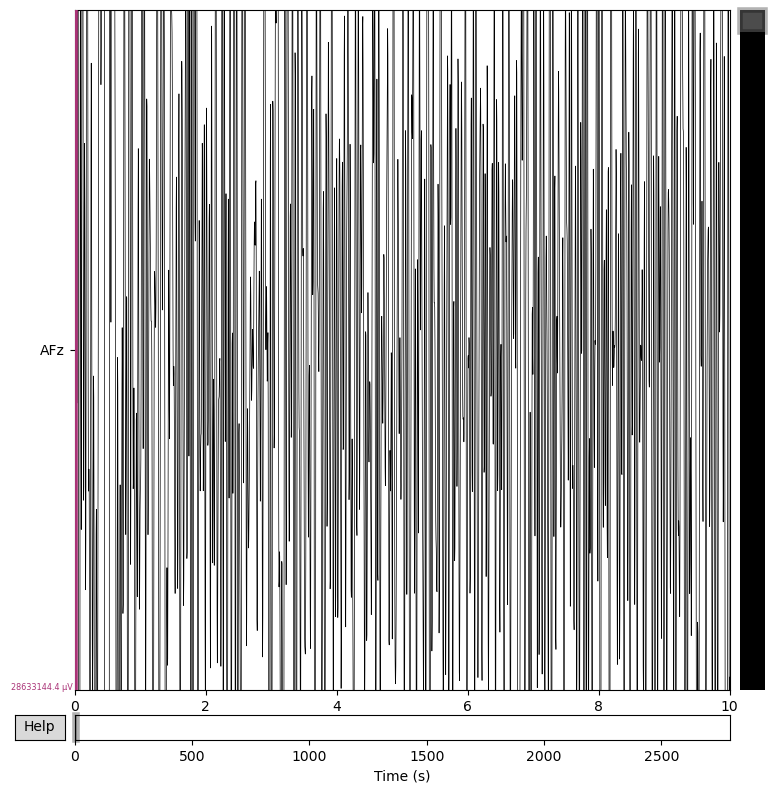

In [18]:
#Showing my first channel across the whole time series - tinker with this to get visualization
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
subject_A_session_1.plot(n_channels=1, scalings=scalings, title='Auto-scaled Data from arrays',
         show=True, block=True);

Now we need to add in the other data that is important for the analysis - when each trial started and ended, what task they were asked to perform, etc. This will use epochs in mne.

Full general walkthrough including adding epochs: https://mne.tools/0.16/auto_examples/io/plot_objects_from_arrays.html#sphx-glr-auto-examples-io-plot-objects-from-arrays-py

**Reading about filtering**
- In general it is common to filter out everything less than 1Hz and between 50 and 70Hz: https://www.medicine.mcgill.ca/physio/vlab/biomed_signals/eeg_n.htm#:~:text=The%20electroencephalogram%20(EEG)%20is%20a,measured%20in%20microvolts%20(mV).
- However, any kind of filtering can create changes in your data and is not in all cases beneficial: https://sapienlabs.org/lab-talk/pitfalls-of-filtering-the-eeg-signal/

## PROGRESS REPORT 2
**Student Check-in:**

|WHAT'S GOING WELL/STRUGGLES|DEVELOPMENT PLAN|INSTRUCTOR FEEDBACK|
|---------------------------|----------------|-------------------|
|Selected, installed, and started using python package for managing EEG data, called MNE|N/A||
|Got all my data downloaded and can open it in MNE|N/A||
|Tagged data properly to turn it into variables & events|N/A||
|Have some early visualizations, but the data is too jumpy to be comprehensible|Been reading about methods for filtering EEG data - or smoothing / averaging, see final bullet point||
|Haven't quite cracked the code on MNEs built in scalers|Need to spend more time experimenting with scaling the data, but could also scale the data with sci kit learn outside of MNE||
|Need to reduce the number of data points per trial (256 Hertz times ten second trials is 2,560 samples for each of 30 channels, too many for deep learning I understand)|Read about this in EEG, but my first thought is to take the average of each 10 readings for each channel||

Notes from conversation with Anirudh:

- I should build a supervised network, that will get the best results
- I should just use tensorflow, don't worry about pytorch
- Make a 3 layer neural net, and feed the input into the last layer (or second to last layer) into tsne to make visualization
- He recommends building neural network progressively - start with a super simple neural net (like with excel data I make on a simple classification problem), put it into tsne and umap (umap keeps things more structurally correct)
- Then go to time series data - LSTM (which is an encoder) - in my neural net
- LSTM isn't going to work with 2500 data points per trial (it just won't run) - I could run a transformer model, but I'm not going to have time for that, instead he suggests getting down to 100 samples per LSTM (bunch of ways to do that, could take the median of every 25 measurements, or just take every 25th one)
- He highly recommends I visualize how each channel moves up and down - that will aid my knowledge hugely
    - I can even do matplotlib + animation (google that) to make a gif of how a channel moves in a trial
- I could also train with an auto encoder, it will take an input in (like you could feed it an image) - and it will try to recreate the signal you are feeding it
    - Google cnn autoencoder
- It may be the only transformation I need to do is put all my datapoints between 0 and 1 - maybe a log transformation - in general the neural nets will handle the transformations, but the cleaner the data I feed them, the better the neural net will work
- Could maybe do convolutional neural network (CNN) instead of LSTM (basically treat the signal as an image instead of timeseries data)
- I should look up the study where they used an auto encoder to have people watch youtube on eeg, and then use the eeg to rebuild the youtube video


Links he used / took me to:
https://projector.tensorflow.org/
'auto encoder in deep learning'
'TSNE' visualizer
https://www.tutorialspoint.com/time_series/time_series_lstm_model.htm#:~:text=It%20is%20special%20kind%20of,layers%20interacting%20with%20each%20other. 


Based on further research:
- Looks like there is already a package to implement tensorflow models with data formatted as mne handles it: https://github.com/zubara/mneflow
    - Unclear if this will help me just apply their three built models to my data or provide an easier path to creating tensorflow models on my data